## Imports

In [54]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torchsummary import summary
import seaborn as sns
from scipy.special import softmax
from functools import partial

import warnings
warnings.filterwarnings("ignore")

from src.plant_pathology.leaf_dataset import LeafDataset
from src.plant_pathology.model_loops import training, validation, testing
from src.plant_pathology.models import get_resnet, get_densenet, get_effecientnet
from src.plant_pathology.visualizations import show_saliency_maps, create_class_visualization

In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


## Reading/Processing the Data

In [57]:
IMAGE_PATH = Path('./plant-pathology-2020-fgvc7/images')

def image_path(file_stem):
    return IMAGE_PATH/f'{file_stem}.jpg'

In [58]:
train_df = pd.read_csv('./plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('./plant-pathology-2020-fgvc7/test.csv')

train_paths = train_df['img_file'] = train_df['image_id'].apply(image_path)
test_paths = test_df['img_file'] = test_df['image_id'].apply(image_path)

train_labels = train_df[['healthy','multiple_diseases','rust','scab']]


In [59]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

### Visualize Data

In [ ]:
import cv2
import imutils
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [ ]:
scab = cv2.imread(str(train_df.iloc[0]['img_file']))
multi = cv2.imread(str(train_df.iloc[1]['img_file']))
rust = cv2.imread(str(train_df.iloc[1819]['img_file']))
healthy = cv2.imread(str(train_df.iloc[4]['img_file']))
kernel = np.ones((6,6),np.float32)/25

types = [healthy, multi, rust, scab]

In [ ]:
fig, axs = plt.subplots(4, 5)
y_labels = ['Healthy', 'Multi', 'Rust', 'Scab']
x_labels = ['Normal', 'Horizontal Flip', 'Vertical Flip', 'Rotated 25', 'Filtered']

for i in range(4):
    axs[i, 0].imshow(types[i])
    axs[i, 0].set(ylabel=y_labels[i])
    axs[i, 1].imshow(cv2.flip(types[i], 1))
    axs[i, 2].imshow(cv2.flip(types[i], 0))
    axs[i, 3].imshow(imutils.rotate(types[i], 25))
    axs[i, 4].imshow(cv2.filter2D(types[i],-1,kernel))
    
    if (i + 1) == 4:
        for j in range(5):
            axs[i, j].set(xlabel=x_labels[j])
    

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

        
fig.set_size_inches(18.5, 10.5)
fig.savefig('example.jpg')

### Initialization

In [60]:
BATCH_SIZE = 20
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]

In [61]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths,train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

### Metrics

In [62]:
weighted_f1 = partial(f1_score, labels=[0, 1, 2, 3], average='weighted')
macro_f1 = partial(f1_score, labels=[0, 1, 2, 3], average='macro')
micro_f1 = partial(f1_score, labels=[0, 1, 2, 3], average='micro')
acc_fns = [accuracy_score, weighted_f1, macro_f1, micro_f1]

#### Please only run one of the net sections before running the training loop

### DenseNet

In [11]:
densenet = get_densenet(train_labels)
model = densenet

In [12]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### ResNet

In [63]:
resnet34 = get_resnet(train_labels)
model = resnet34

In [64]:
optimizer = torch.optim.Adam(resnet34.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Inception

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Training loop

In [65]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = training(model, trainloader, optimizer, scheduler, loss_fn, acc_fns, device, TRAIN_SIZE)
    vl, va, conf_mat = validation(model, validloader, loss_fn, acc_fns, confusion_matrix, device, VALID_SIZE)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        checkpoint = Path('model_checkpoints/')
        checkpoint.mkdir(exist_ok=True)
        torch.save(model.state_dict(), checkpoint/f'{model.__class__.__name__}_epoch_{epoch}.pt')
    
    printstr = f'Epoch: {epoch} , Train loss: {round(tl, 3)}, Val loss: {round(vl, 3)}, Train accs: {[round(t_a, 3) for t_a in ta]}, Val accs: {[round(v_a, 3) for v_a in va]}'
    tqdm.write(printstr)
    

Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 0 , Train loss:  0.76, Val loss: 0.48, Train accs: [0.7, 0.69, 0.54, 0.7], Val accs: [0.88, 0.85, 0.67, 0.88]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 1 , Train loss:  0.47, Val loss: 0.34, Train accs: [0.85, 0.83, 0.68, 0.85], Val accs: [0.92, 0.89, 0.7, 0.92]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 2 , Train loss:  0.36, Val loss: 0.21, Train accs: [0.88, 0.87, 0.75, 0.88], Val accs: [0.93, 0.91, 0.74, 0.93]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 3 , Train loss:  0.44, Val loss: 0.37, Train accs: [0.86, 0.85, 0.71, 0.86], Val accs: [0.9, 0.88, 0.72, 0.9]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 4 , Train loss:  0.4, Val loss: 0.34, Train accs: [0.87, 0.85, 0.69, 0.87], Val accs: [0.9, 0.89, 0.74, 0.9]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 5 , Train loss:  0.42, Val loss: 0.36, Train accs: [0.86, 0.84, 0.7, 0.86], Val accs: [0.9, 0.88, 0.71, 0.9]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 6 , Train loss:  0.4, Val loss: 0.33, Train accs: [0.87, 0.85, 0.71, 0.87], Val accs: [0.9, 0.88, 0.69, 0.9]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 7 , Train loss:  0.36, Val loss: 0.33, Train accs: [0.89, 0.87, 0.74, 0.89], Val accs: [0.88, 0.89, 0.79, 0.88]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 8 , Train loss:  0.34, Val loss: 0.19, Train accs: [0.89, 0.88, 0.73, 0.89], Val accs: [0.94, 0.92, 0.79, 0.94]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 9 , Train loss:  0.38, Val loss: 0.33, Train accs: [0.88, 0.87, 0.74, 0.88], Val accs: [0.9, 0.88, 0.69, 0.9]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 10 , Train loss:  0.34, Val loss: 0.48, Train accs: [0.88, 0.86, 0.7, 0.88], Val accs: [0.85, 0.84, 0.66, 0.85]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 11 , Train loss:  0.31, Val loss: 0.18, Train accs: [0.9, 0.89, 0.77, 0.9], Val accs: [0.95, 0.94, 0.82, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 12 , Train loss:  0.32, Val loss: 0.38, Train accs: [0.89, 0.88, 0.76, 0.89], Val accs: [0.88, 0.87, 0.79, 0.88]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 13 , Train loss:  0.33, Val loss: 0.18, Train accs: [0.89, 0.88, 0.73, 0.89], Val accs: [0.94, 0.94, 0.86, 0.94]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 14 , Train loss:  0.27, Val loss: 0.18, Train accs: [0.9, 0.89, 0.76, 0.9], Val accs: [0.95, 0.94, 0.86, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 15 , Train loss:  0.26, Val loss: 0.17, Train accs: [0.91, 0.9, 0.78, 0.91], Val accs: [0.95, 0.94, 0.85, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 16 , Train loss:  0.26, Val loss: 0.29, Train accs: [0.91, 0.9, 0.79, 0.91], Val accs: [0.91, 0.9, 0.8, 0.91]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 17 , Train loss:  0.26, Val loss: 0.16, Train accs: [0.91, 0.9, 0.78, 0.91], Val accs: [0.95, 0.94, 0.84, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 18 , Train loss:  0.23, Val loss: 0.16, Train accs: [0.92, 0.91, 0.8, 0.92], Val accs: [0.95, 0.94, 0.82, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 19 , Train loss:  0.24, Val loss: 0.14, Train accs: [0.92, 0.91, 0.8, 0.92], Val accs: [0.95, 0.94, 0.83, 0.95]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 20 , Train loss:  0.2, Val loss: 0.23, Train accs: [0.93, 0.93, 0.83, 0.93], Val accs: [0.93, 0.94, 0.87, 0.93]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 21 , Train loss:  0.18, Val loss: 0.14, Train accs: [0.94, 0.93, 0.84, 0.94], Val accs: [0.96, 0.96, 0.89, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 22 , Train loss:  0.17, Val loss: 0.14, Train accs: [0.93, 0.93, 0.84, 0.93], Val accs: [0.96, 0.96, 0.88, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 23 , Train loss:  0.14, Val loss: 0.13, Train accs: [0.95, 0.95, 0.85, 0.95], Val accs: [0.96, 0.96, 0.9, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 24 , Train loss:  0.14, Val loss: 0.13, Train accs: [0.95, 0.95, 0.89, 0.95], Val accs: [0.96, 0.96, 0.9, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 25 , Train loss:  0.12, Val loss: 0.11, Train accs: [0.96, 0.96, 0.93, 0.96], Val accs: [0.96, 0.96, 0.9, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 26 , Train loss:  0.12, Val loss: 0.12, Train accs: [0.96, 0.96, 0.92, 0.96], Val accs: [0.96, 0.95, 0.85, 0.96]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 27 , Train loss:  0.1, Val loss: 0.09, Train accs: [0.97, 0.97, 0.93, 0.97], Val accs: [0.98, 0.97, 0.93, 0.98]


Training:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 28 , Train loss:  0.13, Val loss: 0.09, Train accs: [0.96, 0.96, 0.93, 0.96], Val accs: [0.97, 0.97, 0.92, 0.97]


Validation: 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]


Epoch: 29 , Train loss:  0.1, Val loss: 0.09, Train accs: [0.97, 0.97, 0.94, 0.97], Val accs: [0.98, 0.97, 0.93, 0.98]


In [74]:
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)

### Plots

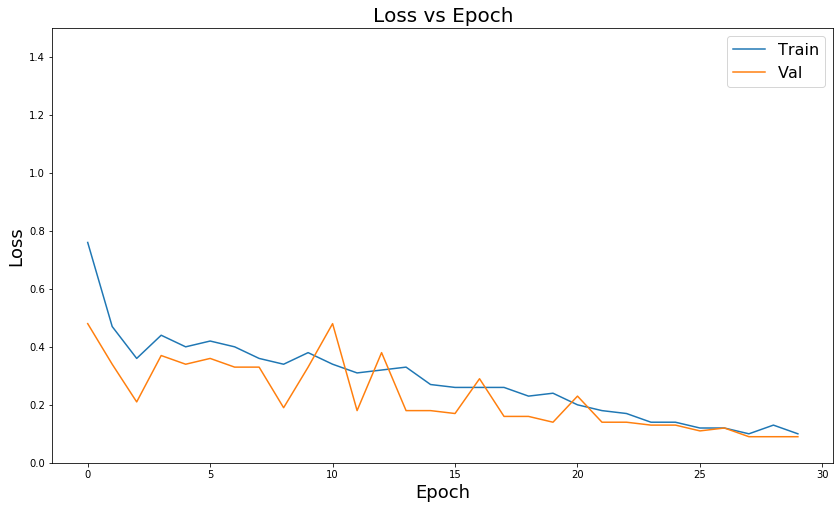

In [75]:
plt.figure(figsize=(14, 8))
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(['Train','Val'], fontsize=16)
plt.title('Loss vs Epoch', fontsize=20)
plt.savefig(f'{model.__class__.__name__}_loss.jpg')

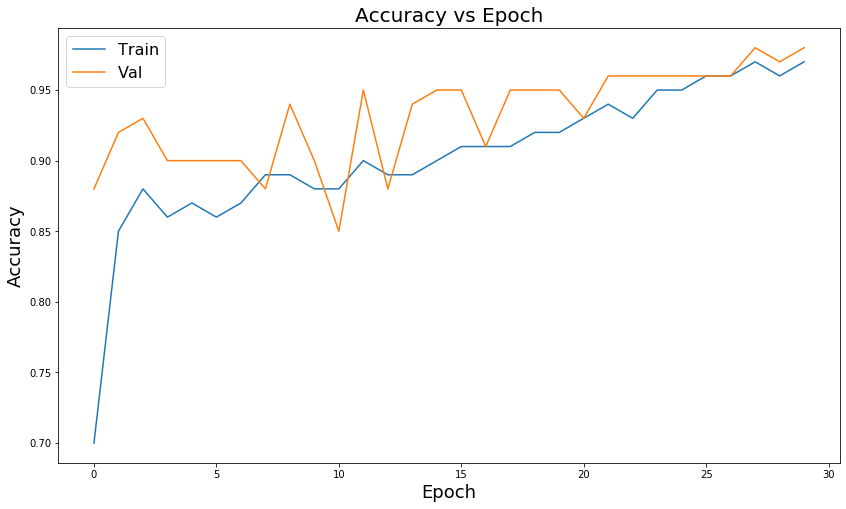

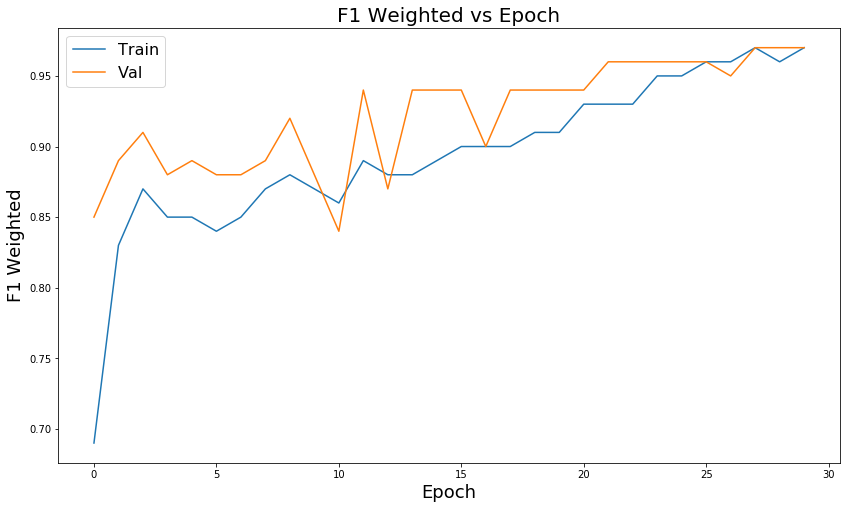

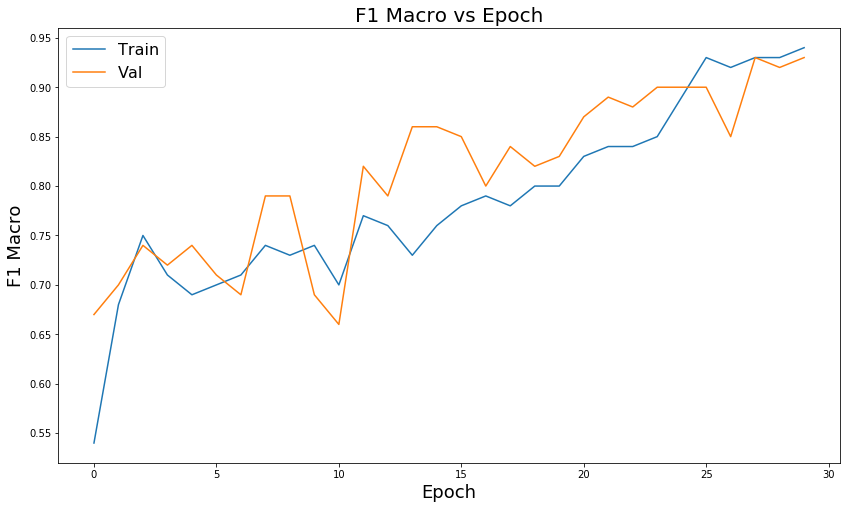

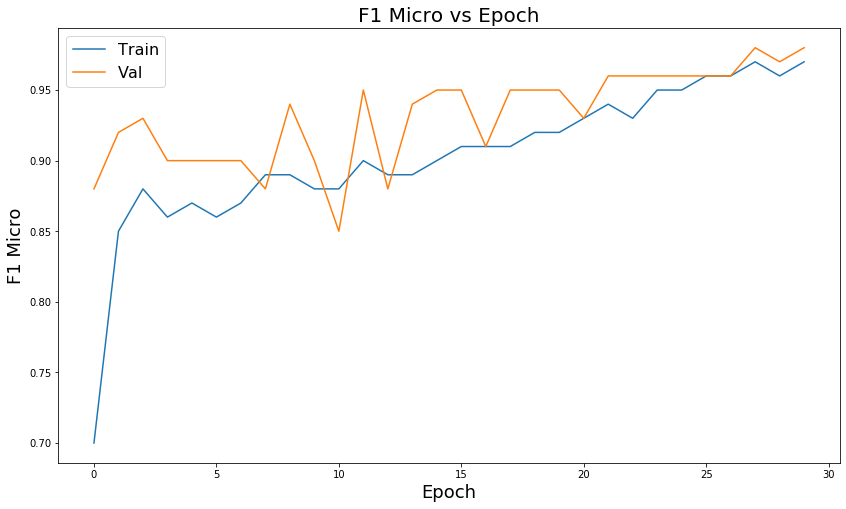

In [76]:
acc_names = ['Accuracy', 'F1 Weighted', 'F1 Macro', 'F1 Micro']
for idx, acc_name in enumerate(acc_names):
    plt.figure(figsize=(14, 8))
    sns.lineplot(list(range(len(train_acc[:, idx]))), train_acc[:, idx])
    sns.lineplot(list(range(len(val_acc[:, idx]))), val_acc[:, idx])
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel(acc_name, fontsize=18)
    plt.legend(['Train','Val'], fontsize=16)
    plt.title(f'{acc_name} vs Epoch', fontsize=20)
    plt.savefig(f'{model.__class__.__name__}_accuracy.jpg')

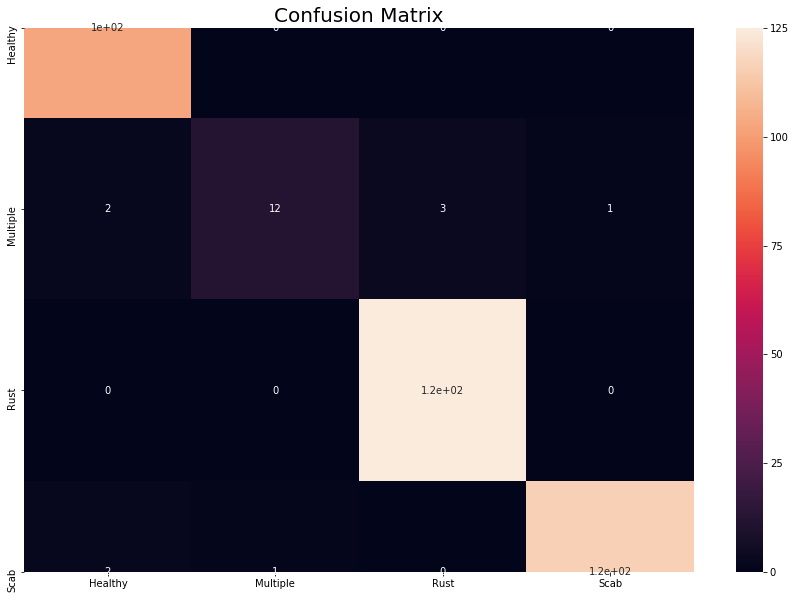

In [77]:
labels = ['Healthy', 'Multiple','Rust','Scab']
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig('confusion.jpg')

### Testing Performance

In [78]:
def get_testing_output(model, device):
    model = model.to(device)
    subs = []
    for i in range(5): #average over 5 runs
        out = testing(model, testloader, device)
        output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
        output.drop(0, inplace = True)
        output.reset_index(drop=True,inplace=True)
        subs.append(output)

    sub_eff1 = sum(subs)/5
    return sub_eff1

### Model Emsembling

In [79]:
densenet_checkpoint = get_densenet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/DenseNet_epoch_29.pt')
resnet_checkpoint = get_resnet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/ResNet_epoch_29.pt')

In [80]:
sub_densenet = get_testing_output(densenet_checkpoint, device)
sub_resnet = get_testing_output(resnet_checkpoint, device)

100%|██████████| 92/92 [01:02<00:00,  1.47it/s]


In [85]:
submission = (sub_densenet + sub_resnet)/2

In [88]:
submission['image_id'] = test_df['image_id']

In [89]:
submission.to_csv('submission.csv', index=False)

### Saliency Maps

In [16]:
model = get_densenet(train_labels, model_path='/home/anishwalawalkar/plant-pathology/model_checkpoints/DenseNet_epoch_29.pt')

In [18]:
class_names = ['Healthy', 'Multi', 'Rust', 'Scab']
y = [0, 1, 2, 3]
X = np.array([
    np.array(Image.open(str(train_df.iloc[1817]['img_file']))),
    np.array(Image.open(str(train_df.iloc[1]['img_file']))),
    np.array(Image.open(str(train_df.iloc[1819]['img_file']))),
    np.array(Image.open(str(train_df.iloc[0]['img_file']))),
])

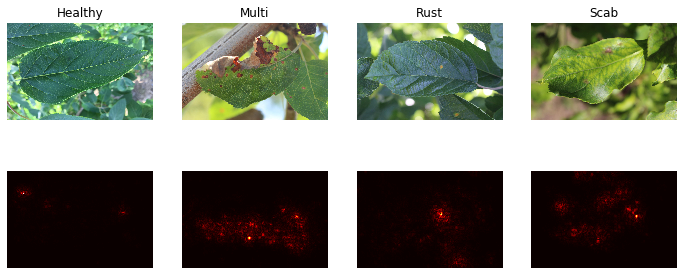

In [20]:
show_saliency_maps(X, y, model, class_names)

### Class Visualization

In [21]:
create_class_visualization(y[0], model.to(device), torch.cuda.FloatTensor, class_names)

AttributeError: 'Tensor' object has no attribute 'square'